This dataset is simulated

Why are our best and most experienced employees leaving prematurely? Have fun with this database and try to predict which valuable employees will leave next. Fields in the dataset include:

Satisfaction Level
Last evaluation
Number of projects
Average monthly hours
Time spent at the company
Whether they have had a work accident
Whether they have had a promotion in the last 5 years
Departments (column sales)
Salary
Whether the employee has left

# Relationships I want to analyze

<li>Satisfaction level vs average monthly hours </li>
<li>Department with highest turnover</li>
<li>last evaluation vs satisfaction level</li>
<li>Deeper analysis of regretted attrition:</li>
    <li>Did they have a recent promotion </li>
    <li>Did they spend too much time at work</li>
    <li>Work accident</li>
    <li>Number of projects</li>
    <li>Last evaluations</li>

In [310]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
##from KaggleAux import predict as ka # see github.com/agconti/kaggleaux for more details

In [334]:
df = pd.read_csv('HR_comma_sep 2.csv')
df.columns
df = df.rename(columns={'sales': 'department'})

In [312]:
df.shape

(14999, 10)

In [313]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [314]:
#Checking for Nulls --- NO NULLS
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [315]:
#isolate the data of those that have quit (left)
dfleft = df[df["left"]==1]
dfstay = df[df["left"]==0]

In [316]:
#Did salary have an influence on the quitting rate of employees?
dfsalaryleft = dfleft.salary.value_counts().sort_index()
dfsalarystay = dfstay.salary.value_counts().sort_index()

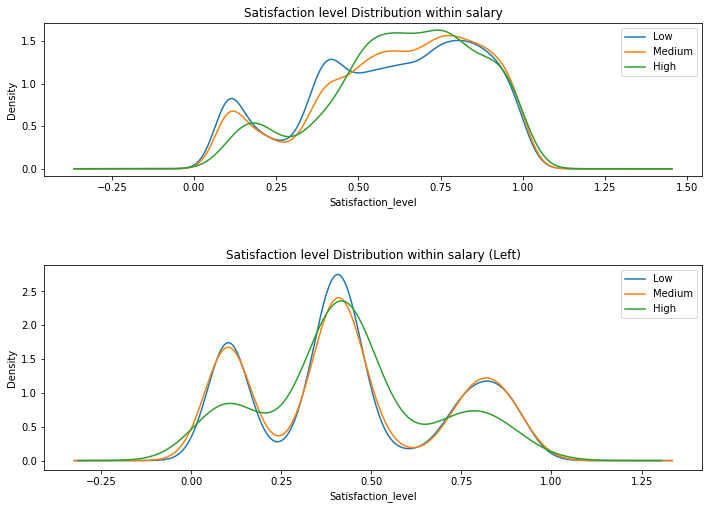

In [317]:
#A look into the distribution rates of Salary vs Satisfaction
fig = plt.figure(figsize=(10,20)) 

plt.subplot2grid((8,2),(0,0), colspan=2)
df.satisfaction_level[df.salary == 'low'].plot(kind='kde')    
df.satisfaction_level[df.salary == 'medium'].plot(kind='kde') 
df.satisfaction_level[df.salary == 'high'].plot(kind='kde') 
# plots an axis lable
plt.tight_layout()
plt.xlabel("Satisfaction_level")    
plt.title("Satisfaction level Distribution within salary")
# sets our legend for our graph.
plt.legend(('Low', 'Medium','High'),loc='best') 

plt.subplot2grid((6,2),(1,0), colspan=2)
dfleft.satisfaction_level[dfleft.salary == 'low'].plot(kind='kde')    
dfleft.satisfaction_level[dfleft.salary == 'medium'].plot(kind='kde') 
dfleft.satisfaction_level[dfleft.salary == 'high'].plot(kind='kde') 
# plots an axis lable
plt.xlabel("Satisfaction_level")    
plt.title("Satisfaction level Distribution within salary (Left)")
# sets our legend for our graph.
plt.legend(('Low', 'Medium','High'),loc='best') 


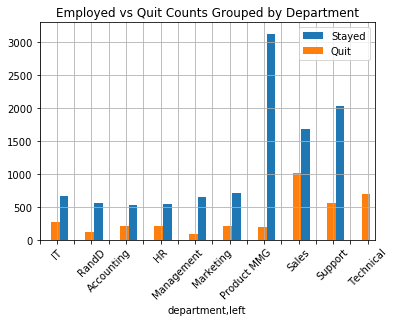

In [318]:
#An analysis of the Employed vs Left employees grouped by Department
depleft = df[['department','left']]
depleft1 = depleft.groupby(['department', 'left'])
ind = np.arange(20)                # the x locations for the groups
width = 0.35                      # the width of the bars
#print (depleft1['left'].value_counts())

#Without the hierarchical indexing
#print ("[Unstacking]")
depleft1sum = depleft1['left'].value_counts().unstack()
#print (depleft1sum)

ax = depleft1sum.plot(kind = 'bar', width = 1,  align='center')

ax.set_xlim(width)
ax.set_ylim(0,3300)
xTickMarks = ['','IT','','RandD','Accounting','','','HR','Management','','Marketing','','Product MMG','','','Sales','','Support','','Technical']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
ax.set_title('Employed vs Quit Counts Grouped by Department')
plt.setp(xtickNames, rotation=45, fontsize=10)
plt.legend(('Stayed', 'Quit'),loc='best') 

#plt.ylabel(‘Num’)
plt.grid()
plt.show()

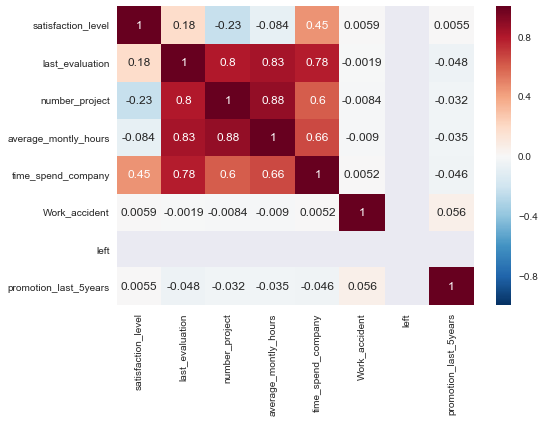

In [336]:
import seaborn as sns
corr=dfleft.corr()
sns.heatmap(corr,annot=True)

In [319]:
#Analysis of regretted attrition 
#last evalutions > .85, number_project > 5, promotion_last_5years = 1
#df[(df["LATITUDE"] == '37.869058') | (df["LONGITUDE"] == '-122.270455')]

retention = dfleft[(dfleft["number_project"] > 5) | (dfleft["promotion_last_5years"] == 1)| (dfleft["last_evaluation"] > .85)]
retention = retention[['satisfaction_level','last_evaluation','promotion_last_5years','salary','number_project']]
retention.head()

,satisfaction_level,last_evaluation,promotion_last_5years,salary,number_project
1,0.80,0.86,0,medium,5
2,0.11,0.88,0,medium,7
3,0.72,0.87,0,low,5
6,0.10,0.77,0,low,6
8,0.89,1.00,0,low,5


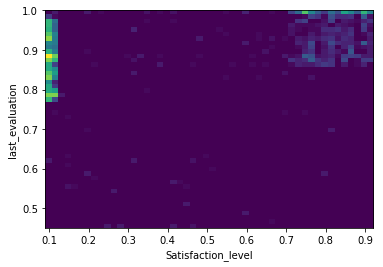

In [320]:
# Generate some test data
x = retention.satisfaction_level
y = retention.last_evaluation

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlabel('Satisfaction_level')
plt.ylabel('last_evaluation')
plt.show()

In [332]:
dummies=pd.get_dummies(df['department'],prefix='sales')
df=pd.concat([df,dummies],axis=1)
df.drop(['department'],axis=1,inplace=True)
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,sales_IT,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,0,1,0,low,0,...,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,...,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,medium,0,...,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,low,0,...,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,low,0,...,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,1,0,low,0,...,0,0,0,0,0,0,0,1,0,0
6,0.10,0.77,6,247,4,0,1,0,low,0,...,0,0,0,0,0,0,0,1,0,0
7,0.92,0.85,5,259,5,0,1,0,low,0,...,0,0,0,0,0,0,0,1,0,0
8,0.89,1.00,5,224,5,0,1,0,low,0,...,0,0,0,0,0,0,0,1,0,0
9,0.42,0.53,2,142,3,0,1,0,low,0,...,0,0,0,0,0,0,0,1,0,0


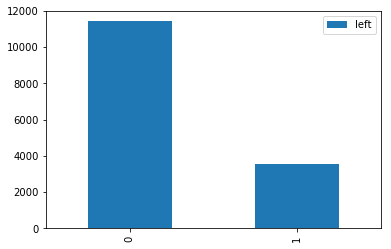

In [321]:
gbl_df = dfdeptleft
gbl_df.plot(kind = 'bar')
plt.show()

In [322]:
dfdeptleft = dfleft.department.value_counts().sort_index().to_frame()
dfdeptstay = dfstay.department.value_counts().sort_index()
dfdeptleft = df.left.value_counts().sort_index().to_frame()
dfdeptleft.head()

,left
0,11428
1,3571


In [337]:
df_left_grouped = df.groupby("department").left.value_counts().to_frame()
df_left_grouped.head()

left
department left      
IT         0      954
           1      273
RandD      0      666
           1      121
accounting 0      563

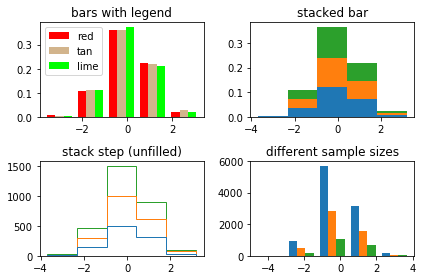

In [328]:
n_bins = 5
x = np.random.randn(1000, 3)

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

colors = ['red', 'tan', 'lime']
ax0.hist(x, n_bins, normed=1, histtype='bar', color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')

ax1.hist(x, n_bins, normed=1, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')

# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()